### Testing Evo

#### Imports

In [1]:
import torch
from IPython.display import display, HTML, Image
from torch_geometric.loader import DataLoader

from settings import *
from generator import generate_organism
from GNCAConv import Conv
from visualizer import Visualizer
from evo_trainer import Evo_Trainer
from enums import EnvironmentType, ModelType
from food_env import *
from online_tracker import OnlineTracker

#%run visualizer.py

#### Train the network

In [2]:
scale = 4
wall_amount = 100*scale
food_amount = 500*scale
centered_env = Centered_Env(food_amount=food_amount, wall_amount=wall_amount//4)
cluster_env = Cluster_Env(clusters=60*scale, cluster_size=15, wall_amount=wall_amount//3)
circle_env = Circle_Env(circles=3*scale, food_amount=food_amount*2, wall_amount=wall_amount)
spiral_env = Spiral_Env(spirals=3, food_amount=food_amount, wall_amount=wall_amount)
bottleneck_env = Bottleneck_Env(food_amount=food_amount//3, wall_amount=(wall_amount*16)//25)
grid_env = Grid_Env(cluster_size=30, grid_size=5*scale)
lab_env = Labyrinth_Env(cluster_size=30, grid_size=3*scale)

In [3]:
train_config = Train_Config(stdev=0.2, popsize=10, 
    name='GAT1_localOnly', problem_searcher=ProblemSearcher.CMAES,
    with_samplepool=False, timesteps=1000)

In [4]:
generations = 10000

settings = Settings(
    device = torch.device('cpu'),
    batch_size = 1,
    cells = 100,
    #food_envs=[centered_env, cluster_env, circle_env, spiral_env],
    food_envs=[spiral_env, cluster_env, circle_env, grid_env, lab_env],
    scale = scale,
    wrap_around = False,
    
    model_type = ModelType.Local,
    #model_type = ModelType.WithGlobalNode,
    #model_type = ModelType.SmallWorld,

    radius = 0.04,
    radius_food_scale = 5,
    consume_radius_scale = 0.8, 
    noise = 0.001,
    energy_required_to_replicate = 50,
    train_config=train_config,
    max_degree = 9,
    #TODO add new max degree on cells

    radius_wall_scale = 5,
    radius_wall_damage_scale = 3,
    wall_damage = 20,
    radius_long_scale=4,
)

In [5]:
#TODO ADD settings like std of clusters..

online_tracker = OnlineTracker(settings)
trainer = Evo_Trainer(settings, online_tracker)
network = Conv(settings=settings)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mmho (gnca). Use `wandb login --relogin` to force relogin


2023-05-08 12:40:58,527	INFO worker.py:1528 -- Started a local Ray instance.


[2023-05-08 12:41:02] INFO     <28067> evotorch.core: Instance of `Custom_NEProblem` (id:11575359088) -- The `dtype` for the problem's decision variables is set as torch.float32
[2023-05-08 12:41:02] INFO     <28067> evotorch.core: Instance of `Custom_NEProblem` (id:11575359088) -- `eval_dtype` (the dtype of the fitnesses and evaluation data) is set as torch.float32
[2023-05-08 12:41:02] INFO     <28067> evotorch.core: Instance of `Custom_NEProblem` (id:11575359088) -- The `device` of the problem is set as cpu
[2023-05-08 12:41:02] INFO     <28067> evotorch.core: Instance of `Custom_NEProblem` (id:11575359088) -- The number of actors that will be allocated for parallelized evaluation is 10
[2023-05-08 12:41:02] INFO     <28067> evotorch.core: Instance of `Custom_NEProblem` (id:11575359088) -- Number of GPUs that will be allocated per actor is None


/Users/martinholst/miniconda3/envs/AML/lib/python3.10/site-packages/evotorch/tools/misc.py:1107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result = torch.tensor(data, **kwargs)


In [8]:
generations=10000

In [9]:
trainer.train(generations)

In [ ]:
network = trainer.get_trained_network()
online_tracker.add_model(network)

#### Visualize trained network

In [ ]:
graphs = [generate_organism(settings).toGraph() for _ in range(settings.batch_size)]
loader = DataLoader(graphs, batch_size=settings.batch_size)
graph = next(iter(loader))
visualizer = Visualizer(settings)
network(graph, 0)

DataBatch(x=[4900, 11], edge_index=[1, 0], device=[1], subsize=[1], velocity=[1], border_cost=[1], food_reward=[1], dead_cost=[1], visible_food=[1], food_avg_dist=[1], food_avg_degree=[1], food_search_movement=[1], cells_alive=[1], batch=[4900], ptr=[2])

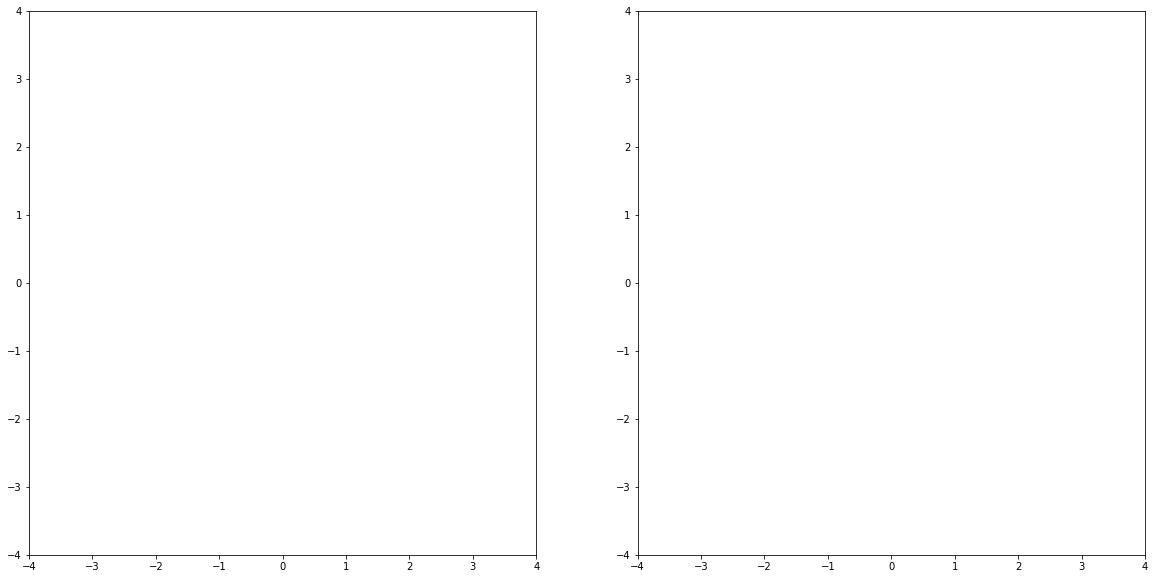

In [ ]:
dpi = 100 #beautiful
#dpi = 50 #fast

anim = visualizer.animate_organism(graph, network) 
visualizer.save_animation_to_gif(anim, train_config.name, fps=10, dpi=dpi)

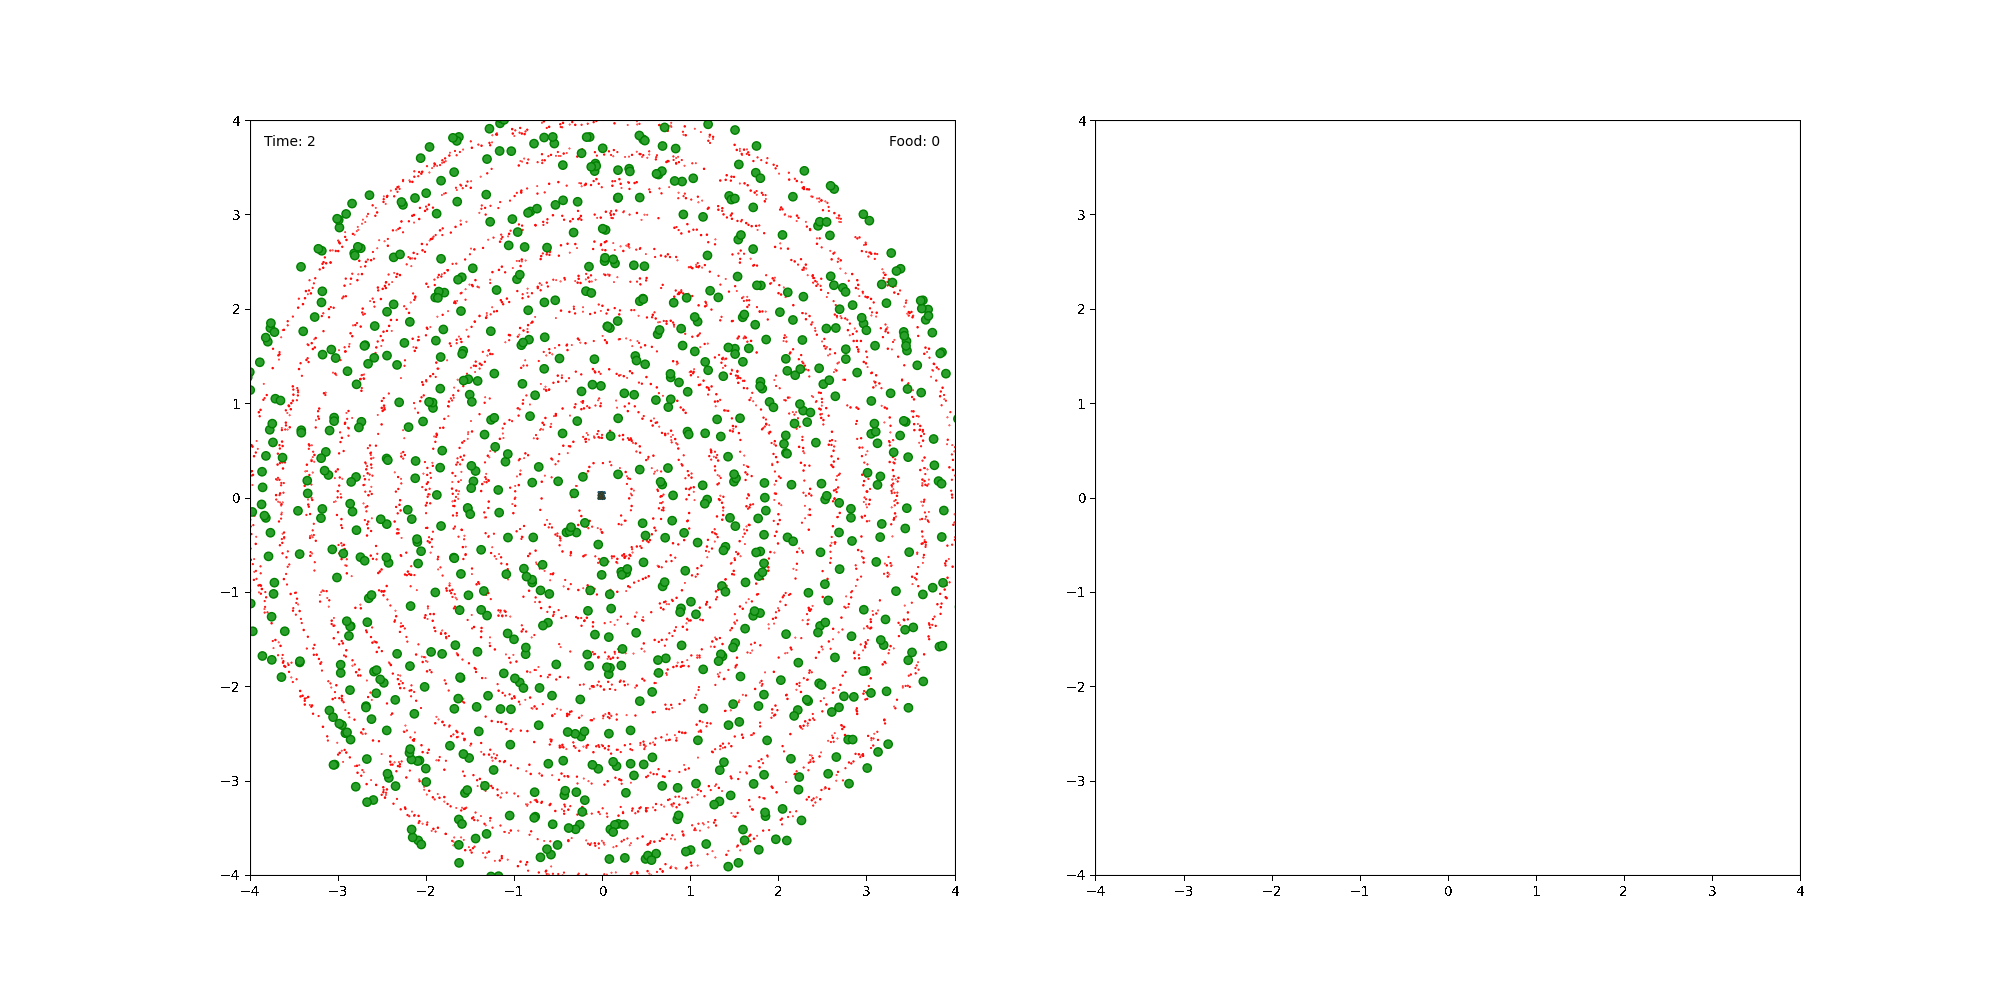

In [ ]:
Image('../animation/' + train_config.name + '.gif')

In [ ]:
%%javascript
IPython.notebook.save_notebook()

<IPython.core.display.Javascript object>

#### Visualization of loss:

In [ ]:
import matplotlib.pyplot as plt
losses = trainer.logger_df
#print(losses)
#plt.plot(losses.stepsize)

if settings.train_config.problem_searcher == ProblemSearcher.GeneticAlgorithm:
    plt.plot(losses.obj0_median_eval)
    plt.plot(losses.obj0_pop_best_eval)
    plt.plot(losses.obj0_mean_eval)
else:
    plt.plot(losses.median_eval)
    plt.plot(losses.pop_best_eval)
    plt.plot(losses.mean_eval)
plt.legend(('median_eval', 'pop_best_eval', 'mean eval'))
plt.show()

In [ ]:
online_tracker.finish()